# Backpropagation


Consider a made-up/fake machine learning model:

$$f(x) = w_3 \cdot\sin( w_2 \cdot\exp(w_1 \cdot x + b_1) + b_2) + b_3$$

and suppose we wish to train this model to fit some real world data.  In other words, we want to find the
best parameters $w_1, w_2, w_3, b_1, b_2, b_3$ to minimize cost:

$$J(w_1, w_2, w_3, b_1, b_2, b_3) = \frac{1}{m}\sum_{i=1}^m L(\hat{y}^{(i)}, y^{(i)})$$

where

$$L(\hat y, y) = \frac{1}{2}(\hat y - y)^2$$

This is the same idea we use for linear regression, except our model function $f$ is slightly more complicated.

However, for the moment, think of this as a *neural network* with one input, one output, and one unit/neuron at each hidden layer.
The activation functions are $\exp()$ for the first layer, $\sin()$ for the second layer, and no activation function (identity)
for the output layer.

**PICTURE**

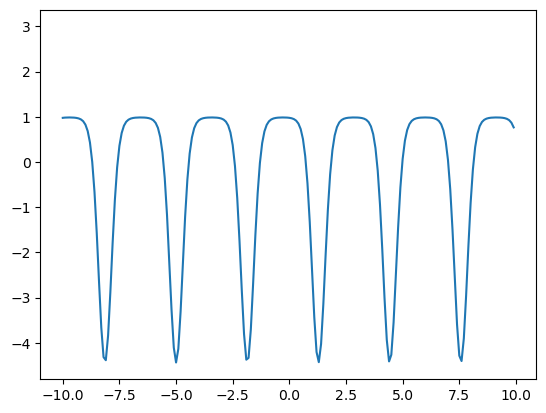

In [23]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
sigmoid = scipy.special.expit
softmax = partial(scipy.special.softmax, axis=1)
relu = lambda x: np.maximum(0, x)

b1 = -1
b2 = -2
b3 = 1
w1 = 2
w2 = 3
w3 = -2

x_data = np.arange(-10, 10, .1)
y_data = b3 + w3 * np.exp(b2 + w2 * np.sin(b1 + w1 * x_data))


plt.plot(x_data, y_data, -3, 3)
plt.show()

The particular shape of this function $f$ above is not important, but we graph it just for completeness.

## Minimizing $J$ with gradient descent

As always, suppose we wish to minimize the cost function, $J$.

As always, suppose we wish to minimize the cost function, $J$.  Because $J$ is a function of six variables
$(w_1, w_2, w_3, b_1, b_2, b_3)$, we need to find six partial derivatives, namely:

$$\frac{\partial J}{\partial w_1}, \quad \frac{\partial J}{\partial w_2}, \quad \frac{\partial J}{\partial w_3}, \quad \frac{\partial J}{\partial b_1}, \quad \frac{\partial J}{\partial b_2}, \quad \frac{\partial J}{\partial b_3} $$

Let's focus on $\frac{\partial J}{\partial J w_1}$ for the moment.  $J$ is a sum of individual loss functions, so we can
calculate:

$$\frac{\partial}{\partial w_1}J(w_1, w_2, w_3, b_1, b_2, b_3) = \frac{\partial}{\partial w_1} \frac{1}{m}\sum_{i=1}^m L(\hat{y}^{(i)}, y^{(i)}) = \frac{1}{m}\sum_{i=1}^m \frac{\partial}{\partial w_1} L(\hat{y}^{(i)}, y^{(i)})$$

because $1/m$ is a constant, and a partial derivative of a sum is the sum of the partial derivatives.

So we really want to focus on $\frac{\partial}{\partial w_1} L(\hat{y}^{(i)}, y^{(i)})$, which we will abbreviate as 

$$\frac{\partial L^{(i)}}{\partial w_1} $$

which we can interpret as "the loss on the $i$'th training example."

We can, of course, directly calculate this partial derivative using the chain rule.  However, it is awkward
to do so without mistakes all at once because treating $L$ as a function of $w_1$ means tracing the loss function
back through $\hat y$, through $f$, and through each intermediate function, all the way back to $w_1$.

The backpropagation algorithm is an eﬀicient method for computing all of these derivatives at once. It consists of (i) a forward pass, in which we compute and store a series of intermediate values and the network output, and (ii) a backward pass, in which we calculate the derivatives of each parameter, starting at the end of the network, and reusing previous calculations as we move toward the start.

## Forward pass

We will treat the computation of $L^{(i)}$ as a series of calculations:

$z_1 = w_1 \cdot x^{(i)} + b_1$ 

$a_1 = \exp(z_1)$

$z_2 = w_2 \cdot a_1 + b_2$ 

$a_2 = \sin(z_2)$

$z_3 = w_3 \cdot a_2 + b_3$

$L^{(i)} = \frac{1}{2}(z_3 - y^{(i)})^2$ because remember ${\hat y}^{(i)} = f(x^{(i)}) = z_3$

We can compute and store all of these variables, because we know all of their values.  (We know the values of the $w$'s
and $b$'s, and the training example $x^{(i)}$.)

## Backward pass:

To complete the backwards pass, we remember the chain rule:

$$\dfrac{\partial}{\partial x} f(g(x)) = \left( f(g(x)) \right)' = f'(g(x)) \cdot g'(x)$$

or 

$$\dfrac{\partial f}{\partial x} = \frac{\partial f}{\partial g} \cdot \dfrac{\partial g}{\partial x}$$

The take-away here is that to compute the derivative of a function composed with another function, you take
the derivative of each of two functions with respect to each function's input variable and multiply them.

We now compute the derivatives of each term with respect to the previous term, but in reverse order:

$\dfrac{\partial L^{(i)}}{\partial z_3} = \dfrac{\partial}{\partial z_3} \dfrac{1}{2}(z_3 - y^{(i)})^2
 = \dfrac{1}{2} \dfrac{\partial}{\partial z_3} (z_3 - y^{(i)})^2 = \dfrac{1}{2}2(z_3 - y^{(i)})\cdot \dfrac{\partial}{\partial z_3}(z_3 - y^{(i)}) = (z_3 - y^{(i)})$

$\dfrac{\partial z_3}{\partial a_2} = \dfrac{\partial}{\partial a_2}(w_3 \cdot a_2 + b_3) = w_3$

$\dfrac{\partial a_2}{\partial z_2} = \dfrac{\partial}{\partial z_2}\sin(z_2) = \cos(z_2)$

$\dfrac{\partial z_2}{\partial a_1} = \dfrac{\partial}{\partial a_2}(w_2 \cdot a_1 + b_2) = w_2$

$\dfrac{\partial a_1}{\partial z_1} = \dfrac{\partial}{\partial z_1}\exp(z_1) = \exp(z_1)$

$\dfrac{\partial z_1}{\partial w_1} = \dfrac{\partial}{\partial w_1}(w_1 \cdot x^{(i)} + b_1) = x^{(i)}$

We can now construct our original derivative:

$$\begin{align*}
\dfrac{\partial L^{(i)}}{\partial w_1} &= 
 \dfrac{\partial L^{(i)}}{\partial z_3}
 \dfrac{\partial z_3}{\partial a_2}
 \dfrac{\partial a_2}{\partial z_2}
 \dfrac{\partial z_2}{\partial a_1}
 \dfrac{\partial a_1}{\partial z_1}
 \dfrac{\partial z_1}{\partial w_1} \\
 &= (z_3 - y^{(i)}) \cdot w_3 \cdot \cos(z_2) \cdot w_2 \cdot \exp(z_1) \cdot x^{(i)}
 \end{align*}
 $$

The take-away here is that in that last term, those are all quantities we know, because we are given them from
the problem ($x^{(i)}$, $y^{(i)}$), they are parameters that we control (the $w$ terms), or we already computed them in the forward pass (the $z$'s and $a$'s).

## So what?

Why is this cool?  The reason this is interesting is that in each layer of the neural network, the partial derivatives are simply multiplied
by the layer before (earlier in the computation).  For instance, for computing $\dfrac{\partial L^{(i)}}{\partial w_2}$, we have

$$\begin{align*}
\dfrac{\partial L^{(i)}}{\partial w_2} &= 
 \dfrac{\partial L^{(i)}}{\partial z_3}
 \dfrac{\partial z_3}{\partial a_2}
 \dfrac{\partial a_2}{\partial z_2}
 \dfrac{\partial z_2}{\partial w_2} \\
 &= (z_3 - y^{(i)}) \cdot w_3 \cdot \cos(z_2) \cdot a_1 
 \end{align*}
 $$

So this is the basis of the backpropagation algorithm, which is both simpler and more eﬀicient than computing the derivatives individually.